In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#PLS
from sklearn.cross_decomposition import PLSRegression
#Clustering
from sklearn.neighbors import KNeighborsClassifier

#reference
from sklearn.model_selection import cross_val_predict

PCA analysis on a fake dataset of weights, heights of men/women

In [4]:
def height(male,mAge):
    sigma=np.std(mAge)
    mu=np.mean(mAge)
    y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (mAge - 25)**2 / (2 * sigma**2))
    if male ==1:
        height = np.arange(1.6,2.1,0.01)-y
    else:
        height = np.arange(1.5,2,0.01)-y
    return height

In [5]:
Agem = np.abs(np.random.normal(50,20,50).round(0))+5
Agef = np.abs(np.random.normal(50,25,50).round(0))+5
mHeight = height(1,Agem)
mWeight = ((mHeight)*mHeight*23 + np.random.normal(0,3,len(mHeight))+Agem/10).round(1)

fHeight = height(0,Agef)
fWeight = ((fHeight)*fHeight*23 + np.random.normal(0,3,len(fHeight))-10+Agef/10).round(1)

Text(0.5, 1.0, 'Height and weight for men and women\n size=Age')

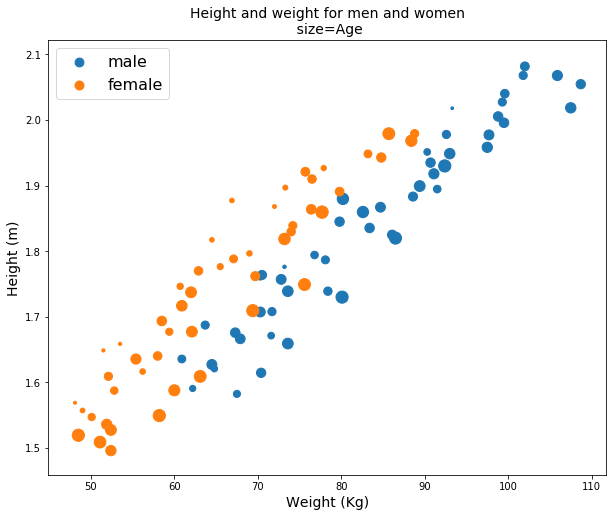

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(mWeight,mHeight,s=Agem*1.5, label='male')
plt.scatter(fWeight,fHeight, s=Agef*1.5, label='female')
plt.xlabel('Weight (Kg)',fontsize=14)
plt.ylabel('Height (m)', fontsize=14)
plt.legend(fontsize=16)
plt.title('Height and weight for men and women\n size=Age', fontsize=14)

In [22]:
df = pd.DataFrame()
df1 = pd.DataFrame()
df['Weight'] = mWeight
df['Height'] = mHeight
df['Age'] = Agem
df['Sex'] = 'male'
df1['Weight'] = fWeight
df1['Height'] = fHeight
df1['Age'] = Agef
df1['Sex'] = 'female'
df = pd.concat([df,df1],axis=0)
df = pd.get_dummies(df,drop_first=True)
df['Height'] = np.round(df['Height'],2)

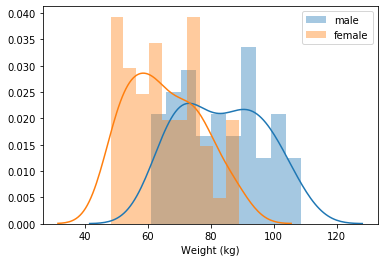

In [23]:
sns.distplot(df[df.Sex_male==1]['Weight'], bins=10, label='male')
sns.distplot(df[df.Sex_male==0]['Weight'], bins=10, label='female')
plt.xlabel('Weight (kg)')
plt.legend();

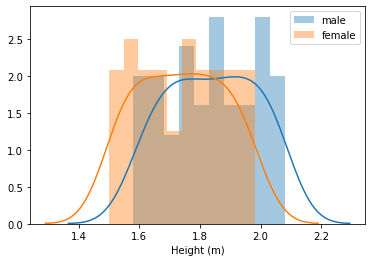

In [24]:
sns.distplot(df[df.Sex_male==1]['Height'], bins=10, label='male')
sns.distplot(df[df.Sex_male==0]['Height'], bins=10, label='female')
plt.xlabel('Height (m)')
plt.legend();

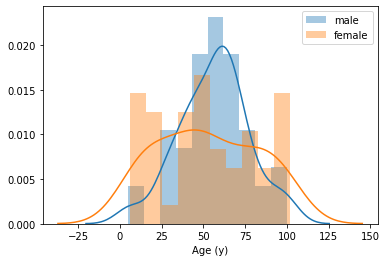

In [25]:
sns.distplot(df[df.Sex_male==1]['Age'], bins=10, label='male')
sns.distplot(df[df.Sex_male==0]['Age'], bins=10, label='female')
plt.xlabel('Age (y)')
plt.legend();

In [26]:
df.groupby('Sex_male').mean()

,Weight,Height,Age
Sex_male,,,
0,65.216,1.7386,52.5
1,83.294,1.8386,56.1


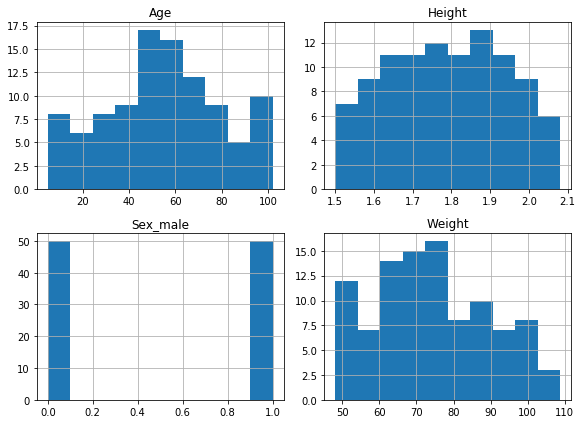

In [27]:
df.hist(figsize=(8,6))
plt.tight_layout()

In [28]:
df.describe(include='all')

,Weight,Height,Age,Sex_male
count,100.000000,100.000000,100.000000,100.000000
mean,74.255000,1.788600,54.300000,0.500000
std,15.393842,0.153491,25.586257,0.502519
min,48.100000,1.500000,5.000000,0.000000
25%,62.175000,1.667500,37.750000,0.000000
50%,73.200000,1.785000,55.500000,0.500000
75%,85.800000,1.912500,71.250000,1.000000
max,108.700000,2.080000,102.000000,1.000000


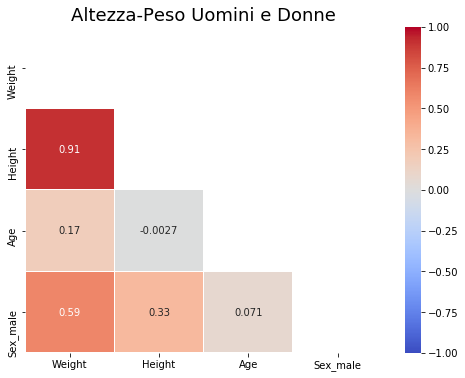

In [29]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,6))
plt.tight_layout()
plt.title('Altezza-Peso Uomini e Donne', fontsize=18)
sns.heatmap(corr,cmap='coolwarm', linewidths=0.1,annot=True, mask=mask,vmin=-1,vmax=1);
#plt.savefig('imgs/CorrPlot-1MS-A', dpi=150,bbox_inches = "tight")

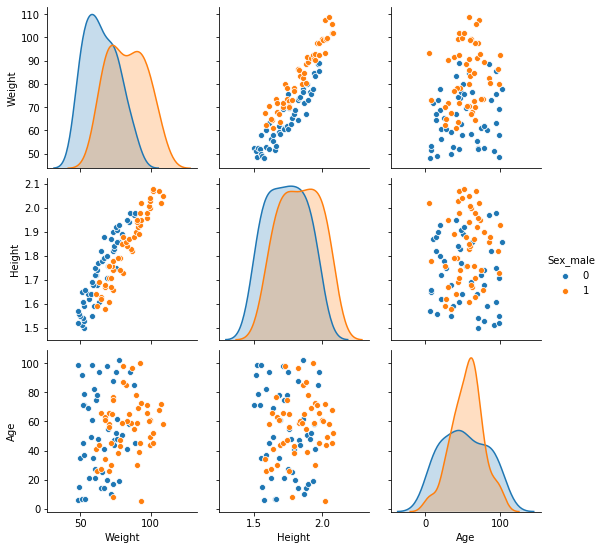

In [30]:
sns.pairplot(hue='Sex_male',data=df);

# PCA

In [31]:
df.head()

,Weight,Height,Age,Sex_male
0,67.5,1.58,34.0,1
1,62.2,1.59,26.0,1
2,70.4,1.61,58.0,1
3,64.5,1.63,66.0,1
4,64.8,1.62,27.0,1


In [32]:
from scipy.stats import f

In [33]:
def T_Q_calc(scores,pca,data_scaled,Model_Conf=None,model_std=[]):

        T = scores
        X2 = data_scaled
        var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
        ncomp = len(var)
        if len(model_std) != 0:
            Tsq = np.sum((T/model_std)**2, axis=1)
        else:
            Tsq = np.sum((T/np.std(T, axis=0))**2, axis=1)
            model_std = np.std(T, axis=0)

        Err = X2 - pca.inverse_transform(T)
        Q = np.sum(Err**2,axis=1)
        
        if Model_Conf == None:
            conf = 0.95
            Tsq_conf =  f.ppf(q=conf, dfn=ncomp, dfd=X2.shape[0])*ncomp*(X2.shape[0]-1)/(X2.shape[0]-ncomp)
            print('T conf', Tsq_conf)

            i = np.max(Q)+1
            print('Entering Q conf loop')
            while 1-np.sum(Q>i)/np.sum(Q>0) > conf:
                i -= 1
            Q_conf = i
            print('Q conf ok', Q_conf)
        else:
            Tsq_conf , Q_conf = Model_Conf
            
        return Tsq,Q,Tsq_conf,Q_conf,model_std
    
def resume_df(scores,Tsq,Q,Tsq_conf,Q_conf):
    Bad = pd.DataFrame()
    for i in range(min(4,2)):
                Bad['PC'+str(i)] = scores[:,i]

    Bad['R3'] = np.sqrt(scores[:,0]**2+scores[:,1]**2)
    Bad['Tsq'] = Tsq
    Bad['Q'] = Q
    Bad['CheckT'] = Bad['Tsq'].apply(lambda x: 1 if x>Tsq_conf else 0)
    Bad['CheckQ'] = Bad['Q'].apply(lambda x: 1 if x>Q_conf else 0)
    Bad['SumCheck'] = Bad['CheckT']+Bad['CheckQ']
    Bad['Q_conf'] =  Q_conf
    Bad['Tsq_conf'] = Tsq_conf
    return Bad

In [40]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df) #fit the scaling to our dataframe and transform the data
pca = PCA(n_components=2) #covariant Matrix

x_pca = pca.fit_transform(scaled_data)
Tsq,Q,Tsq_conf,Q_conf,mod_std = T_Q_calc(x_pca,pca,scaled_data)
std_df = resume_df(x_pca,Tsq,Q,Tsq_conf,Q_conf)
std_df['ref'] = 1
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var 

T conf 6.237597824125386
Entering Q conf loop
Q conf ok 2.11583031542291


array([56.8, 81.8])

In [41]:
std_df.head()

,PC0,PC1,R3,Tsq,Q,CheckT,CheckQ,SumCheck,Q_conf,Tsq_conf,ref
0,-0.721595,0.480467,0.866919,0.459948,2.944413,0,1,1,2.11583,6.237598,1
1,-0.945090,0.799507,1.237904,1.031903,3.013817,0,1,1,2.11583,6.237598,1
2,-0.374528,-0.402001,0.549433,0.223200,2.150193,0,1,1,2.11583,6.237598,1
3,-0.513286,-0.685371,0.856269,0.585219,1.962100,0,0,0,2.11583,6.237598,1
4,-0.714023,0.801573,1.073475,0.866324,2.597397,0,1,1,2.11583,6.237598,1


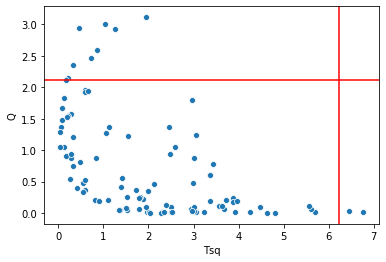

In [42]:
sns.scatterplot(x='Tsq', y='Q', data=std_df)
plt.axvline(Tsq_conf, color='r')
plt.axhline(Q_conf, color='r')

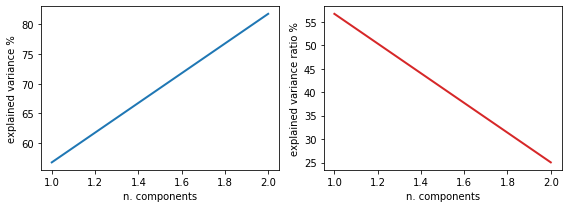

In [43]:
var = pca.explained_variance_ratio_.cumsum()*100
var_ratio = pca.explained_variance_ratio_*100
x = range(1,len(var)+1)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x,var, lw=2, color='tab:blue')
plt.xlabel('n. components')
plt.ylabel('explained variance %')
plt.subplot(1,2,2)
plt.plot(x,var_ratio,lw=2, color='tab:red')
plt.xlabel('n. components')
plt.ylabel('explained variance ratio %')
plt.tight_layout()

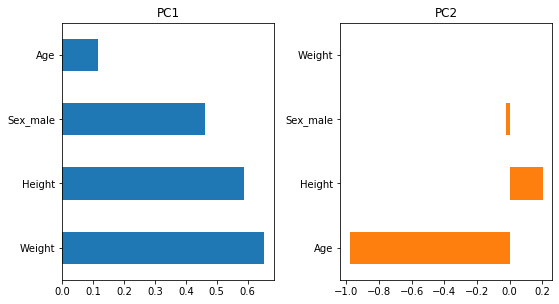

In [44]:
indexes = ['PC'+str(x) for x in range(len(pca.components_))]
loadings = pd.DataFrame(pca.components_, columns=df.columns.tolist(),index=indexes)
        
plt.figure(figsize=(8,12))
        # grafico al massimo 6 componenti
for i in range(min(len(pca.components_),6)):
        colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        sort_load = loadings.T.abs().sort_values(by='PC'+str(i),ascending=False)[0:15].index.values
        plt.subplot(3,2,i+1)
        loadings.iloc[i,:][sort_load].T.plot.barh(color=colors[i])
        plt.title('PC'+str(i+1))
plt.tight_layout() 

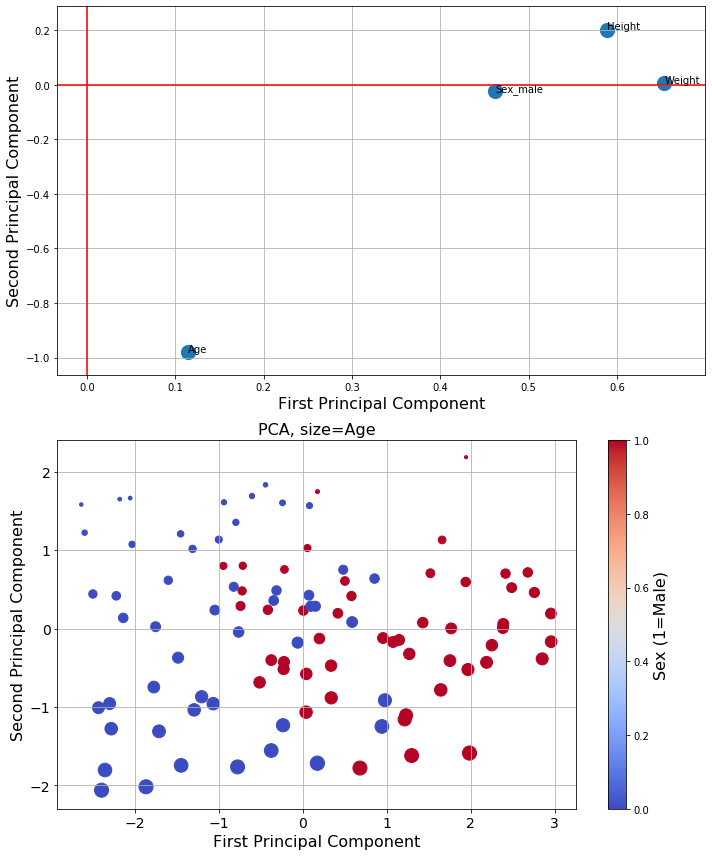

In [45]:
columns = df.columns
x=pca.components_[0,:]
y=pca.components_[1,:]


fig, ax = plt.subplots(2,1,figsize=(10,12))
ax[0].scatter(x, y,s=200)
#ax[0].set_xlim(-0.5,0.5)
#ax[0].set_ylim(-0.5,0.5)
ax[0].set_xlabel('First Principal Component', fontsize=16)
ax[0].set_ylabel('Second Principal Component', fontsize=16)
ax[0].grid()
ax[0].axhline(c='r')
ax[0].axvline(c='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



for i, txt in enumerate(columns):
    ax[0].annotate(txt, (x[i], y[i]))
    
cbar2 = np.asarray(df['Sex_male']) 
sc = ax[1].scatter(x_pca[:,0],x_pca[:,1],c=cbar2, cmap='coolwarm', s=df['Age']*2)

ax[1].set_xlabel('First Principal Component', fontsize=16)
ax[1].set_ylabel('Second Principal Component', fontsize=16)
ax[1].set_title('PCA, size=Age', fontsize=16)
plt.colorbar(sc, ax=ax[1]).set_label('Sex (1=Male)', fontsize=16)
ax[1].grid()
fig.tight_layout()

In [46]:
new_data = pd.DataFrame([100,1.5,45,1], index=df.columns).T
new_data = new_data.append(pd.Series([50,2,30,0], index=df.columns), ignore_index=True)
new_data

,Weight,Height,Age,Sex_male
0,100.0,1.5,45.0,1.0
1,50.0,2.0,30.0,0.0


In [51]:
new_scaled = scaler.transform(new_data)
new_pca = pca.transform(new_scaled)
Tsq,Q,Tsq_conf,Q_conf,mod_std = T_Q_calc(new_pca,pca,new_scaled,(Tsq_conf,Q_conf),model_std=mod_std)
check_df = resume_df(new_pca,Tsq,Q,Tsq_conf,Q_conf)
check_df['ref'] = 0

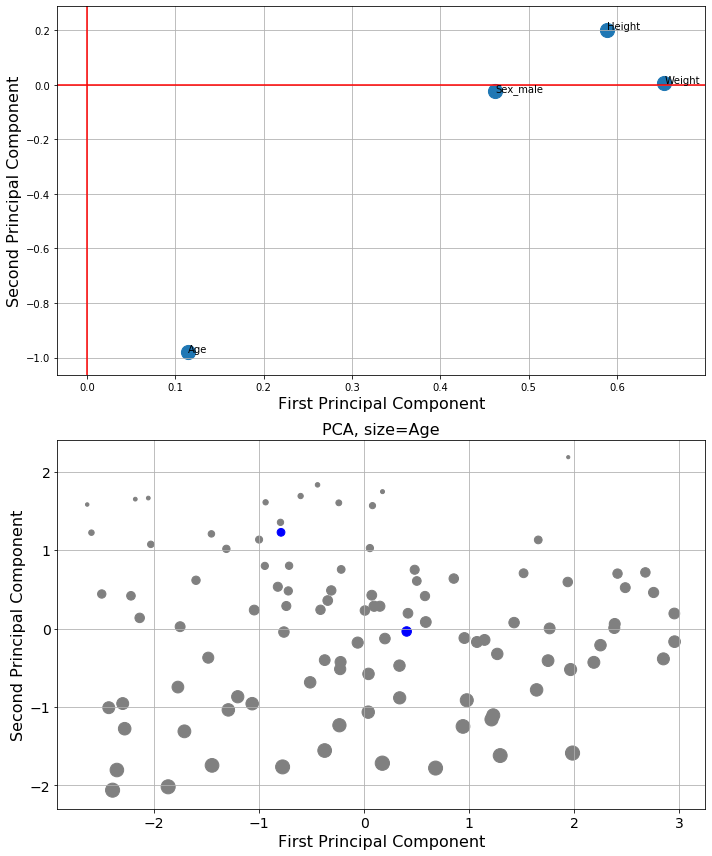

In [52]:
columns = df.columns
x=pca.components_[0,:]
y=pca.components_[1,:]


fig, ax = plt.subplots(2,1,figsize=(10,12))
ax[0].scatter(x, y,s=200)
#ax[0].set_xlim(-0.5,0.5)
#ax[0].set_ylim(-0.5,0.5)
ax[0].set_xlabel('First Principal Component', fontsize=16)
ax[0].set_ylabel('Second Principal Component', fontsize=16)
ax[0].grid()
ax[0].axhline(c='r')
ax[0].axvline(c='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



for i, txt in enumerate(columns):
    ax[0].annotate(txt, (x[i], y[i]))
    
#cbar1 = np.asarray(df['Sex_male']) 
#cbar2 = np.asarray(new_data['Sex_male']) 
sc = ax[1].scatter(x_pca[:,0],x_pca[:,1],c='grey', s=df['Age']*2)
sc2 = ax[1].scatter(new_pca[:,0],new_pca[:,1],c='blue', s=new_data['Age']*2)

ax[1].set_xlabel('First Principal Component', fontsize=16)
ax[1].set_ylabel('Second Principal Component', fontsize=16)
ax[1].set_title('PCA, size=Age', fontsize=16)
#plt.colorbar(sc2, ax=ax[1]).set_label('Sex (1=Male)', fontsize=16)
ax[1].grid()
fig.tight_layout()

In [53]:
check_df.head()

,PC0,PC1,R3,Tsq,Q,CheckT,CheckQ,SumCheck,Q_conf,Tsq_conf,ref
0,0.406132,-0.036813,0.407797,0.074016,7.363391,0,1,1,2.11583,6.237598,0
1,-0.790898,1.227744,1.460437,1.781063,4.201954,0,1,1,2.11583,6.237598,0


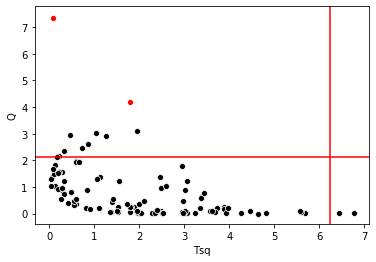

In [54]:
sns.scatterplot(x='Tsq', y='Q', data=std_df,color='k')
sns.scatterplot(x='Tsq', y='Q', data=check_df,color='r')
plt.axvline(Tsq_conf, color='r')
plt.axhline(Q_conf, color='r')

With PCA and the three variables the axis are now oriented to the maximum variance. This is not enough to discriminate male/females.

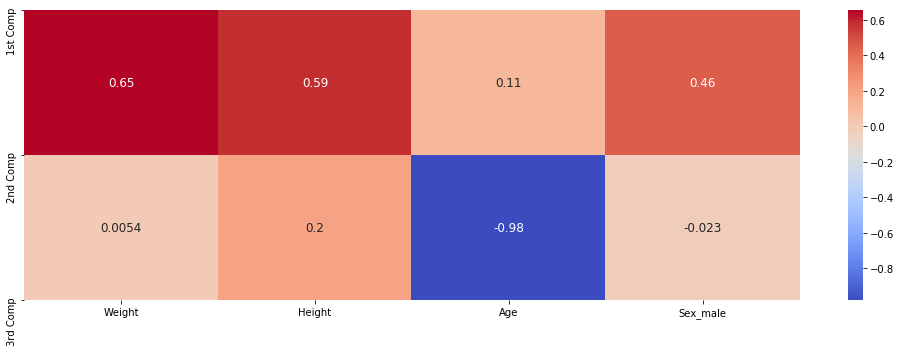

In [55]:
df_comp = pd.DataFrame(pca.components_,columns=df.columns)
plt.figure(figsize=(14,5))
sns.heatmap(df_comp,cmap='coolwarm', annot=True,annot_kws={"size": 12})
plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=10)
plt.tight_layout()

# scaling with three features

In [57]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop('Sex_male',axis=1)) #fit the scaling to our dataframe and transform the data
pca = PCA(n_components=3) #covariant Matrix

x_pca = pca.fit_transform(scaled_data)

variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var 

array([ 64.3,  97.7, 100. ])

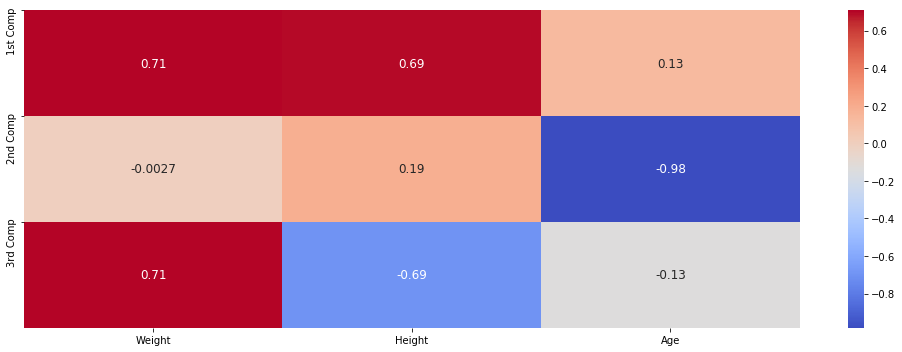

In [58]:
df_comp = pd.DataFrame(pca.components_,columns=df.drop('Sex_male',axis=1).columns)
plt.figure(figsize=(14,5))
sns.heatmap(df_comp,cmap='coolwarm', annot=True,annot_kws={"size": 12})
plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=10)
plt.tight_layout()

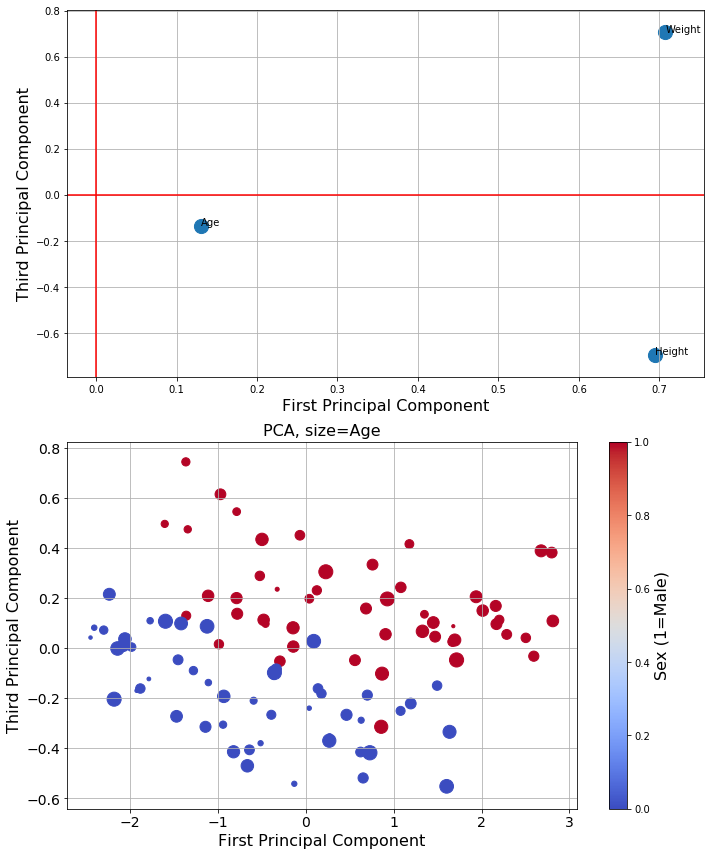

In [59]:
columns = df.drop('Sex_male',axis=1).columns
x=pca.components_[0,:]
y=pca.components_[2,:]


fig, ax = plt.subplots(2,1,figsize=(10,12))
ax[0].scatter(x, y,s=200)
#ax[0].set_xlim(-0.5,0.5)
#ax[0].set_ylim(-0.5,0.5)
ax[0].set_xlabel('First Principal Component', fontsize=16)
ax[0].set_ylabel('Third Principal Component', fontsize=16)
ax[0].grid()
ax[0].axhline(c='r')
ax[0].axvline(c='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



for i, txt in enumerate(columns):
    ax[0].annotate(txt, (x[i], y[i]))
    
cbar2 = np.asarray(df['Sex_male']) 
sc = ax[1].scatter(x_pca[:,0],x_pca[:,2],c=cbar2, cmap='coolwarm', s=df['Age']*2)

ax[1].set_xlabel('First Principal Component', fontsize=16)
ax[1].set_ylabel('Third Principal Component', fontsize=16)
ax[1].set_title('PCA, size=Age', fontsize=16)
plt.colorbar(sc, ax=ax[1]).set_label('Sex (1=Male)', fontsize=16)
ax[1].grid()
fig.tight_layout()

# LDA

In [60]:
df.head()

,Weight,Height,Age,Sex_male
0,67.5,1.58,34.0,1
1,62.2,1.59,26.0,1
2,70.4,1.61,58.0,1
3,64.5,1.63,66.0,1
4,64.8,1.62,27.0,1


In [62]:
X = df.iloc[:,:3].copy() #Selecting the variables
target = df['Sex_male'].copy() #the target

In [68]:
LDA = LinearDiscriminantAnalysis(n_components=1) # The n_components key word gives us the projection to the n most discriminative directions in the dataset. We set this parameter to two to get a transformation in two dimensional space.  
#n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3, 2 - 1) = 1 components.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

data_projected = LDA.fit_transform(scaled_data,target)
print(data_projected.shape)

(100, 1)


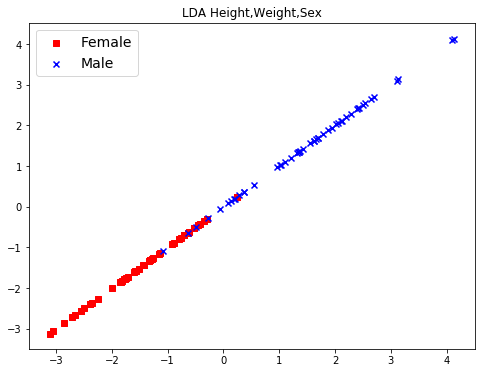

In [69]:
# PLot the transformed data
markers = ['s','x']
colors = ['r','b']
fig = plt.figure(figsize=(8,6))
ax0 = fig.add_subplot(111)
for l,m,c in zip(np.unique(target),markers,colors):
    if l==1:
        lab = 'Male'
    else:
        lab= 'Female'
    ax0.scatter(data_projected[:,0][target==l],data_projected[:,0][target==l],c=c,marker=m, label=lab)
    
plt.title('LDA Height,Weight,Sex')
plt.legend(fontsize=14)

# Linear Regression

In [70]:
df.head()

,Weight,Height,Age,Sex_male
0,67.5,1.58,34.0,1
1,62.2,1.59,26.0,1
2,70.4,1.61,58.0,1
3,64.5,1.63,66.0,1
4,64.8,1.62,27.0,1


In [71]:
X = df[['Weight','Height','Age']]
y = df.Sex_male

In [72]:
from sklearn import linear_model
import statsmodels.api as sm
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X,y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 4.936678254022157
Coefficients: 
 [ 0.06740651 -5.10373564 -0.00577178]


In [73]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:               Sex_male   R-squared (uncentered):                   0.730
Model:                            OLS   Adj. R-squared (uncentered):              0.722
Method:                 Least Squares   F-statistic:                              87.64
Date:                Mon, 13 Jul 2020   Prob (F-statistic):                    1.64e-27
Time:                        10:42:39   Log-Likelihood:                         -41.678
No. Observations:                 100   AIC:                                      89.36
Df Residuals:                      97   BIC:                                      97.17
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Multi Linear Regression

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

In [75]:
X = df[['Weight','Height','Age']]
y = df.Sex_male

In [76]:
num_sample = len(y)
inf_plt = min(y)-0.1
sup_plt = max(y)+0.1

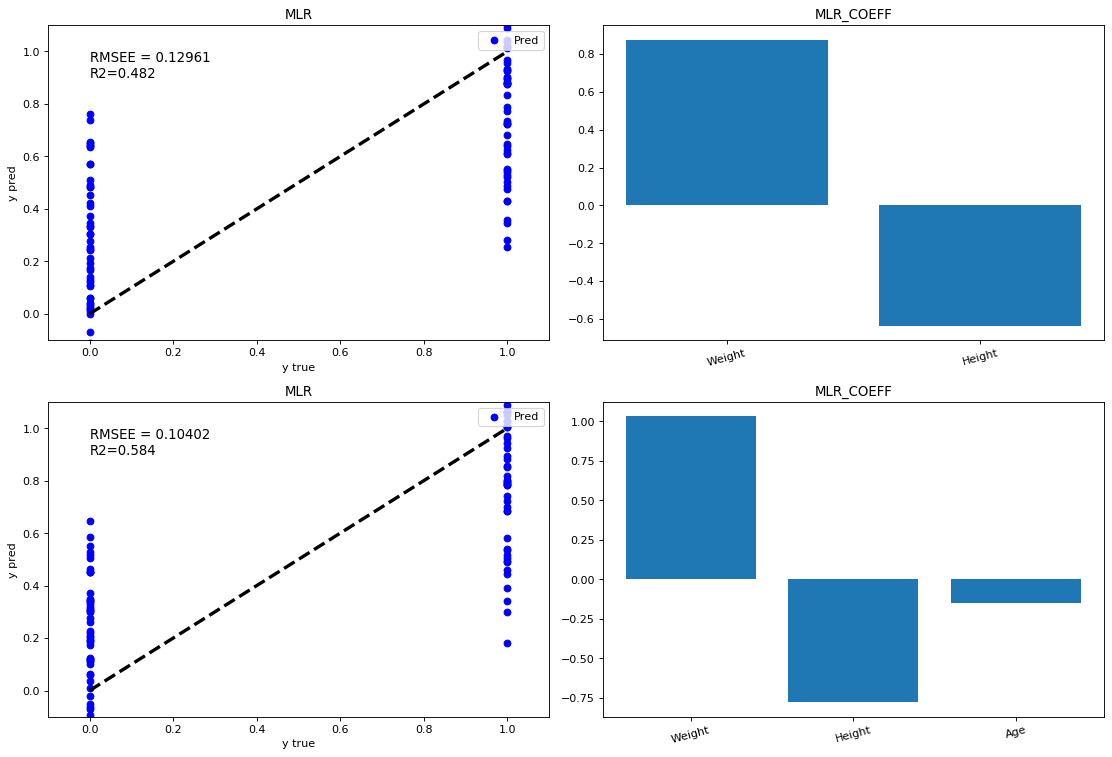

In [77]:
fig = plt.figure(figsize=(14,28), dpi=80)
i=1
ii=0
regr=LinearRegression()
stdsc = StandardScaler()
Var_selz_all = [[0,1],[0,1,2]]

for i in range(len(Var_selz_all)):
    Var_selz = Var_selz_all[i]
    y_pred = cross_val_predict(regr, stdsc.fit_transform(X.iloc[:,Var_selz]), y, cv=10)
    y_pred_rmsee = mean_squared_error(y,y_pred)
    y_pred_r2=r2_score(y,y_pred)
    
    plt.subplot(6,2,i*2+1)
    plt.scatter(y, y_pred, color='blue',label='Pred')
    plt.plot([y.min(),y.max()], [y.min(),y.max()], 'k--', lw=3)
    plt.title('MLR')
    plt.xlabel('y true')
    plt.ylabel('y pred')
    plt.legend(loc=1)
    
    textstr = '\n'.join(('RMSEE = %.5f' % (y_pred_rmsee, ), 'R2=%.3f' % (y_pred_r2,)))
    plt.text(inf_plt+0.1, sup_plt-0.2, textstr, fontsize=12)
    
    plt.xlim((inf_plt, sup_plt))
    plt.ylim((inf_plt,sup_plt))
    i+=1
    
    regr = LinearRegression()
    regr.fit(stdsc.fit_transform(X.iloc[:,Var_selz]), y)
    plt.subplot(6,2,ii*2+2)
    plt.bar(X.iloc[:,Var_selz].columns.values, regr.coef_, tick_label=X.iloc[:,Var_selz].columns.values)
    plt.title('MLR_COEFF')
    plt.xticks(rotation=15)
    ii+=1
plt.tight_layout()

# PLS - Partial Least Squares (Latent Structures)

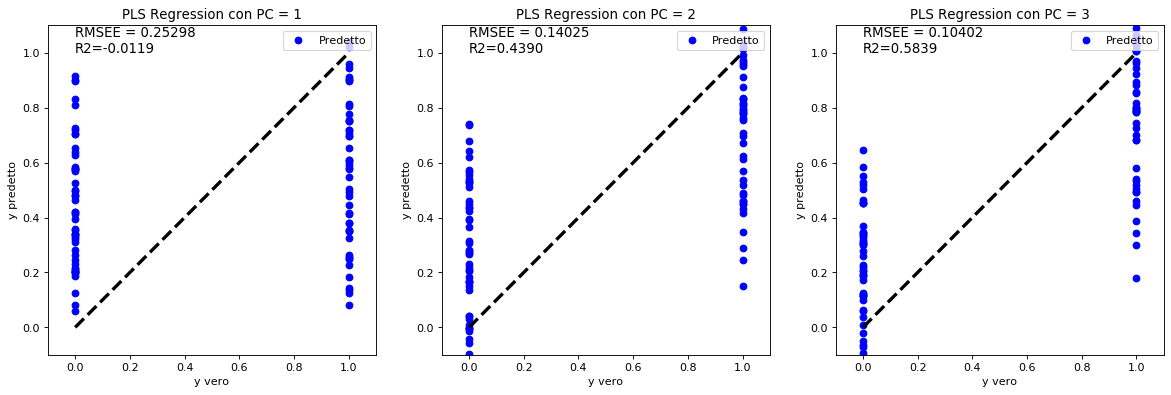

In [78]:
fig = plt.figure(figsize=(18,12), dpi=80, facecolor='w', edgecolor='k')
Var_selz = [0,1,2]

for i in range(1,4):
    regr_pls = PLSRegression(n_components=i)
    
    regr_pls.fit(X,y)
    y_pred_pls = cross_val_predict(regr_pls, X.iloc[:,Var_selz], y, cv=10)
    y_pred_rmsee = mean_squared_error(y,y_pred_pls)
    y_pred_r2=r2_score(y,y_pred_pls)
    
    plt.subplot(2,3,i)
    plt.scatter(y, y_pred_pls, color='blue',label='Predetto')
    plt.plot([y.min(),y.max()], [y.min(),y.max()], 'k--', lw=3)
    plt.title('PLS Regression con PC = '+str(i))
    plt.xlabel('y vero')
    plt.ylabel('y predetto')
    plt.legend(loc=1)
    
    textstr = '\n'.join(('RMSEE = %.5f' % (y_pred_rmsee, ), 'R2=%.4f' % (y_pred_r2,)))
    plt.text(inf_plt+0.1, sup_plt-0.1, textstr, fontsize=12)
    
    plt.xlim((inf_plt, sup_plt))
    plt.ylim((inf_plt,sup_plt))
    i+=1

Text(0.5, 1.0, 'y_Load')

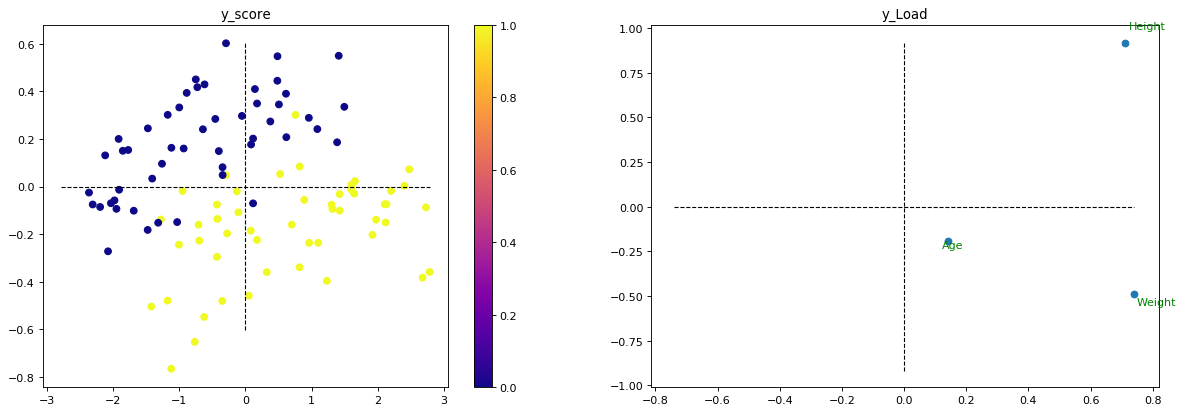

In [79]:
fig = plt.figure(figsize=(18,6), dpi=80, facecolor='w',edgecolor='k')
regr_pls = PLSRegression(n_components=3)
PLS_score=regr_pls.fit_transform(X.iloc[:,Var_selz],y)
PLS_loads=regr_pls.x_loadings_

plt.subplot(1,2,1)
plt.scatter(PLS_score[0][:,0],PLS_score[0][:,1], c=y, cmap='plasma')
plt.plot([PLS_score[0][:,0].max()*-1, PLS_score[0][:,0].max()], [0,0], 'k--',lw=1)
plt.plot([0,0],[PLS_score[0][:,1].max()*-1, PLS_score[0][:,1].max()], 'k--',lw=1)
plt.colorbar()
plt.title('y_score')
plt.subplot(1,2,2)
plt.scatter(PLS_loads[:,0],PLS_loads[:,1])

for i in range(len(PLS_loads)):
    plt.text(PLS_loads[i,0]*1.1, PLS_loads[i,1]*1.1, X.iloc[:,Var_selz].columns.values[i], color='g', ha = 'center', va ='center')
    
plt.plot([PLS_loads[:,0].max()*-1,PLS_loads[:,0].max()], [0,0], 'k--', lw=1)
plt.plot([0,0], [PLS_loads[:,1].max()*-1, PLS_loads[:,1].max()], 'k--', lw=1)
plt.title('y_Load')

In [80]:
def PLS(X,y,lab):
    regr_pls = PLSRegression(n_components=3)
    PLS_score=regr_pls.fit_transform(X,y)
    PLS_loads=regr_pls.x_loadings_
    
    fig = plt.figure(figsize=(9,14), dpi=80, facecolor='w',edgecolor='k')
    plt.subplot(2,1,1)

    #for i in range(len(PLS_score[0])):
    #    plt.text(PLS_score[0][i,0]*1.0, PLS_score[0][i,1]*1.1, s=100,color='k', ha = 'center', va ='center')

    plt.scatter(PLS_score[0][:,0],PLS_score[0][:,1], c=y, cmap='coolwarm',edgecolor='k', s=100)
    plt.plot([PLS_score[0][:,0].max()*-1, PLS_score[0][:,0].max()], [0,0], 'k--',lw=1)
    plt.plot([0,0],[PLS_score[0][:,1].max()*-1, PLS_score[0][:,1].max()], 'k--',lw=1)
    plt.colorbar(label=lab)
    plt.title('y_score')
    plt.grid()

    plt.subplot(2,1,2)
    plt.scatter(PLS_loads[:,0],PLS_loads[:,1], s=120, edgecolor='k')

    for i in range(len(PLS_loads)):
        plt.text(PLS_loads[i,0]*1.1, PLS_loads[i,1]*1.1, X.columns.values[i], color='k', ha = 'center', va ='center')

    plt.plot([PLS_loads[:,0].max()*-1,PLS_loads[:,0].max()], [0,0], 'k--', lw=1,)
    plt.plot([0,0], [PLS_loads[:,1].max()*-1, PLS_loads[:,1].max()], 'k--', lw=1)
    plt.title('y_Load')
    plt.grid()
    
    return (PLS_score,PLS_loads)

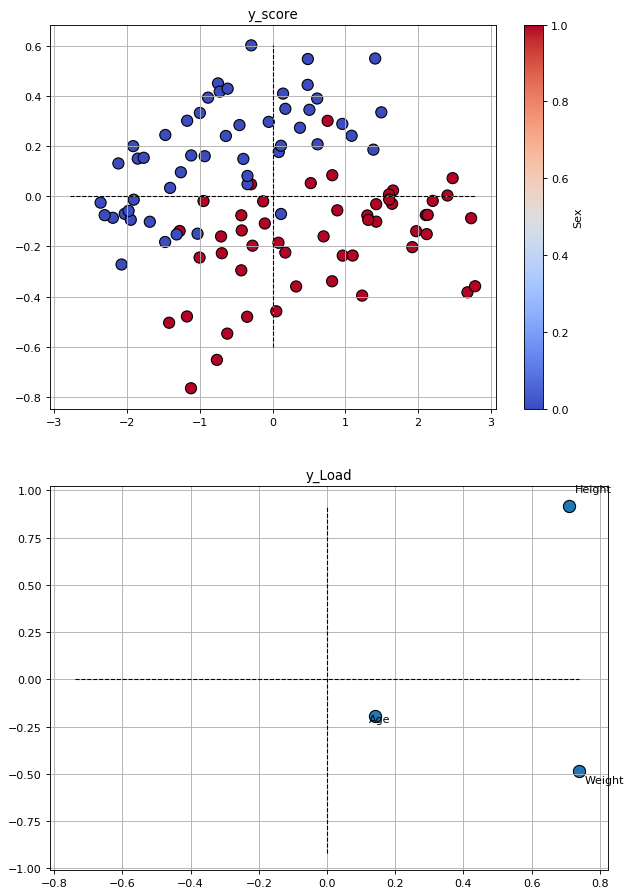

In [81]:
X = df[['Weight','Height','Age']]
y = df.Sex_male
PLS_score,PLS_loads = PLS(X,y,'Sex')